
-> Regression Results (HistGradientBoosting + Poly)
Mean Squared Error (MSE): 7302.16
R² Score: -0.15

-> Classification Results (Stacked)
Accuracy: 67.35%
Classification Report:
               precision    recall  f1-score   support

     Healthy       0.29      0.11      0.16       205
   Unhealthy       0.72      0.89      0.80       527

    accuracy                           0.67       732
   macro avg       0.50      0.50      0.48       732
weighted avg       0.60      0.67      0.62       732



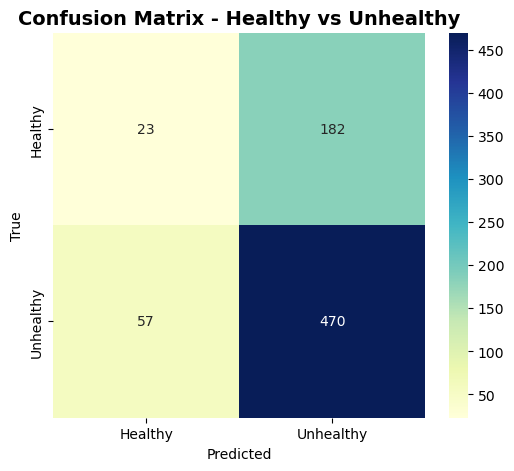

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingRegressor, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# ----------------------------
# Load Dataset
# ----------------------------
file_path = "preprocessed_air_quality.csv"
df = pd.read_csv(file_path)

# Convert Date to datetime format
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Handle missing values
df = df.fillna(df.median(numeric_only=True))

# Feature Engineering
if 'Date' in df.columns:
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day

# Categorize AQI into levels
def categorize_aqi(aqi):
    if aqi <= 50: return 'Good'
    elif aqi <= 100: return 'Moderate'
    elif aqi <= 150: return 'Unhealthy for Sensitive'
    elif aqi <= 200: return 'Unhealthy'
    elif aqi <= 300: return 'Very Unhealthy'
    else: return 'Hazardous'

if 'AQI' in df.columns:
    df['AQI_Level'] = df['AQI'].apply(categorize_aqi)

# ----------------------------
# Encode categorical variables
# ----------------------------
df_encoded = df.copy()
for col in df_encoded.select_dtypes(include=['object']).columns:
    if col not in ['AQI_Level']:
        df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

# ----------------------------
# Regression: Predict AQI
# ----------------------------
X_reg = df_encoded.drop(columns=['Date', 'AQI', 'AQI_Level'], errors='ignore')
y_reg = df_encoded['AQI']

# Polynomial features for better fit
poly = PolynomialFeatures(degree=2, include_bias=False)
X_reg_poly = poly.fit_transform(X_reg)

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg_poly, y_reg, test_size=0.2, random_state=42
)

scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

# HistGradientBoosting for better performance
reg_model = HistGradientBoostingRegressor(
    max_iter=500, learning_rate=0.05, max_depth=8, random_state=42
)
reg_model.fit(X_train_reg_scaled, y_train_reg)
y_pred_reg = reg_model.predict(X_test_reg_scaled)

print("\n-> Regression Results (HistGradientBoosting + Poly)")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test_reg, y_pred_reg):.2f}")
print(f"R² Score: {r2_score(y_test_reg, y_pred_reg):.2f}")

# ----------------------------
# Classification: Healthy vs Unhealthy
# ----------------------------
df['AQI_Binary'] = df['AQI_Level'].apply(lambda x: 'Healthy' if x in ['Good','Moderate'] else 'Unhealthy')

X_clf = df_encoded.drop(columns=['Date', 'AQI', 'AQI_Level'], errors='ignore')
y_clf = df['AQI_Binary']

label_encoder = LabelEncoder()
y_clf_encoded = label_encoder.fit_transform(y_clf)

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf_encoded, test_size=0.2, random_state=42
)

scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

# Balance data using SMOTE
smote = SMOTE(random_state=42)
X_train_clf_res, y_train_clf_res = smote.fit_resample(X_train_clf_scaled, y_train_clf)

# Stacking Classifier (RF + Logistic Regression)
base_clf = [
    ('rf', RandomForestClassifier(n_estimators=400, max_depth=20, random_state=42))
]
stack_clf = StackingClassifier(
    estimators=base_clf,
    final_estimator=LogisticRegression(max_iter=1000),
    n_jobs=-1
)
stack_clf.fit(X_train_clf_res, y_train_clf_res)
y_pred_clf = stack_clf.predict(X_test_clf_scaled)

print("\n-> Classification Results (Stacked)")
print(f"Accuracy: {accuracy_score(y_test_clf, y_pred_clf)*100:.2f}%")
print("Classification Report:\n", classification_report(
    y_test_clf, y_pred_clf, target_names=label_encoder.classes_, zero_division=0
))

# ----------------------------
# 📊 Visualizations
# ----------------------------
cm = confusion_matrix(y_test_clf, y_pred_clf)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - Healthy vs Unhealthy", fontsize=14, weight='bold')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
